# Cle Elum Ridge (CER) Treatment Manuscript Scripts 
## `figure4_deltadce_treatment_maps.ipynb` which is a copy of `figure9_sdv_treatment_defined_by_deltadce.ipynb` with edits

created by Cassie Lumbrazo\
last updated: July 2025\
run location: UAS Linux\
python environment: **cer_treatment**

In [1]:
# import packages 
# %matplotlib widget
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
# ds = xr.open_dataset('~/RAPID/cer_treatment_region_dataset_all_variables/cer_treatment_region_dataset_all_variables.nc') # Steven's path
# ds = xr.open_dataset('C:\\Users\\Lumbr\\OneDrive - UW/Documents\\Washington\\EasternCascades\\Python\\CER_treatment_manuscript\\cer_treatment_region_dataset_all_variables.nc') # Cassie local path
figure_path = '/home/cassie/data/cer_treatment_manuscript/figures/' # Cassie remote path on new linux machine

ds = xr.open_dataset('/home/cassie/data/cer_treatment_manuscript/cer_treatment_region_dataset_all_variables.nc') # Cassie remote path on new linux machine

---

In [3]:
ds

<xarray.Dataset> Size: 5GB
Dimensions:                           (x: 2564, y: 1388, band: 1)
Coordinates:
  * x                                 (x) float64 21kB 4.65e+05 ... 4.676e+05
  * y                                 (y) float64 11kB 2.111e+05 ... 2.097e+05
  * band                              (band) int32 4B 1
    spatial_ref                       int32 4B ...
Data variables: (12/337)
    chmws_rapid                       (band, y, x) float32 14MB ...
    dce_rapid                         (band, y, x) float32 14MB ...
    giulia_dce_rapid                  (band, y, x) float32 14MB ...
    giulia_dce_ncalm                  (band, y, x) float32 14MB ...
    slope                             (band, y, x) float32 14MB ...
    aspect                            (band, y, x) float32 14MB ...
    ...                                ...
    hs_rapid_baf_new_100s_n           (band, y, x) float32 14MB ...
    hs_rapid_baf_new_30s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_60s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_80s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_90s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_100s_s           (band, y, x) float32 14MB ...

In [4]:
color_cat1='olivedrab' # forest growth (forest to denser forest)
color_cat2='cornflowerblue' # forest thinning (forest to forest edge)
color_cat3='black' # no change (delta DCE close to zero)
color_cat4='mediumseagreen' # forest growth (open to less open)
color_cat5='saddlebrown' # forest thinning (open to more open)
color_cat6='darkslateblue' # forest thinning (forest to open)

In [5]:
# Constants 
# colors
colorpre='darkslategray'
colorpos='royalblue'
# colorpos='mediumvioletred'

colorsouth = 'darkorange'
colornorth = 'darkblue'

# colorcontrol = 'dimgray'
colorcontrol = 'saddlebrown'
colortreatment = 'darkcyan'
colortreatment2 = 'darkslategrey'

### Compute Standardized Depth Values (SDV)

We want to compare maps of snow depth on two different years, but rather than compare their depths directly, we will use a standardized depth value (SDV). SDV relates how snow depth in a single pixel or point relates to the mean and standard deviation of snow depths throughout the study area. In this way we can see how a single pixel relates to the snow depths in the study area in year 1, then again in year 2, and see if there was a significant change.

Because we anticipate snow depths changing due to changes in forest structure, we should use the mean and standard deviation of the "control" areas where no human-made forest structure change occurred. Additionally, areas with a snow depth of 0 do not provide us with any information (we don't know how snow in that pixel related to the snow depths across the rest of the study area) and therefore should be removed. Areas with a snow depth of 0 in either year should be removed from *both* years so that we can directly compare changes in pairs of pixels with information in both years.

We can then look at histogram or CDF plots to see how distribution of SDV changed between the two years.

---

### Add Code from `11_delta_dce_categories.ipynb` to normalize snow depth the same way as we do for the delta dce

In [6]:
# Calculate delta DCE
delta_dce = ds['dce_rapid'] - ds['dce_ncalm']

# Create a new variable to store the categories
# Category 1: Forest Growth: forest to denser forest (ncalm negative, rapid negative, delta DCE negative)
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] < 0) & (delta_dce < 0), 1, 0)

# Category 2: Forest Thinning: forest to forest edge (ncalm negative, rapid negative, delta DCE positive) 
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] < 0) & (delta_dce > 0), 2, ds['delta_dce_cat'])

# Category 3: No Change (delta DCE close to zero (absolute value less than 0.5))
ds['delta_dce_cat'] = xr.where(np.abs(delta_dce) < 0.5, 3, ds['delta_dce_cat'])

# Category 4: Forest Growth: open to less open (ncalm positive, rapid less than ncalm) 
# ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (ds['dce_rapid'] < ds['dce_ncalm']), 4, ds['delta_dce_cat']) # how I had it writen
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (delta_dce < 0), 4, ds['delta_dce_cat']) # matching Susan's code exactly

# Category 5: Forest Thinning: open to more open (ncalm positive, rapid greater than ncalm)
# ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (ds['dce_rapid'] > ds['dce_ncalm']), 5, ds['delta_dce_cat']) # how I had it writen
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (delta_dce > 0), 5, ds['delta_dce_cat']) # matching Susan's code exactly

# Category 6: Forest Thinning: forest to open (ncalm negative, rapid positive)
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] > 0), 6, ds['delta_dce_cat'])

#### DeltaDCE Catgeories, 
* Category 1: Forest Growth (forest to denser forest) --> non-treatment area  
* Catgeory 2: Forest Thinning (forest to forest edge) --> treatment area 
* Catgeory 3: No Change --> non-treatment area
* Catgeory 4: Forest Growth (open to less open) --> non-treatment area 
* Catgeory 5: Forest Thinning (open to more open) --> treatment area 
* Catgeory 6: Forest Thinning (forest to open) --> treatment area 

## Redefine Treatment Areas 
So the catgeories which define forest thinning are the "treatment" areas now, and the categories which define forest growth or no change are the "control" or "non-treatment" areas, 
* `Treatment Area: Category 2, 5, 6`
* `Non-Treatment Area: Catgeory 1, 3, 4`

In [7]:
# Calculate mean and standard deviation of snow depth for delta DCE category 3 (no change)
mean_2021 = ds['hs_ncalm'].where(ds['delta_dce_cat'] == 3).mean()
std_2021 = ds['hs_ncalm'].where(ds['delta_dce_cat'] == 3).std()

mean_2023 = ds['hs_rapid'].where(ds['delta_dce_cat'] == 3).mean()
std_2023 = ds['hs_rapid'].where(ds['delta_dce_cat'] == 3).std()

# Normalize snow depth for each year
ds['hs_ncalm_normalized'] = (ds['hs_ncalm'] - mean_2021) / std_2021
ds['hs_rapid_normalized'] = (ds['hs_rapid'] - mean_2023) / std_2023

# Calculate the difference in normalized snow depth 
ds['hs_diff_normalized'] = ds['hs_rapid_normalized'] - ds['hs_ncalm_normalized']

# Print the means and stds 
print('ΔDCE Category 3 Mean 2021:', mean_2021.values.round(3))
print('ΔDCE Category 3 Mean 2023:', mean_2023.values.round(3))
print('ΔDCE Category 3 Std 2021:', std_2021.values.round(3))
print('ΔDCE Category 3 Std 2023:', std_2023.values.round(3))

ΔDCE Category 3 Mean 2021: 0.167
ΔDCE Category 3 Mean 2023: 0.198
ΔDCE Category 3 Std 2021: 0.225
ΔDCE Category 3 Std 2023: 0.235


Before computing SDV, we should remove all locations that had a depth value of 0 in either year 1 or year 2. When we have a depth of 0, we don't actually know how this location compares (in terms of SDV, or number of standard deviations from the mean) with the rest of the study area.

In [8]:
ds['hs_ncalm_zeros_removed'] = ds['hs_ncalm'].where((ds.hs_rapid!=0)&(ds.hs_ncalm!=0))
ds['hs_rapid_zeros_removed'] = ds['hs_rapid'].where((ds.hs_rapid!=0)&(ds.hs_ncalm!=0))

### Compute SDV

SDV = (measured snow depth at a point - the mean depth for the survey) / the standard deviation of the survey

We only want to base the SDV mean and standard deviation on the "control areas" where there was no prescribed forest structure change the BAF data variable is NaN for the "control" areas (np.isnan(ds.baf)), and has a value in the "treatment" areas (~np.isnan(ds.baf)).

In [9]:
ds['sdv_rapid'] = (ds['hs_rapid_zeros_removed'] - ds['hs_rapid_zeros_removed'].where(np.isnan(ds.baf)).mean(dim=['x','y'])) / ds['hs_rapid_zeros_removed'].where(np.isnan(ds.baf)).std(dim=['x','y'])
ds['sdv_ncalm'] = (ds['hs_ncalm_zeros_removed'] - ds['hs_ncalm_zeros_removed'].where(np.isnan(ds.baf)).mean(dim=['x','y'])) / ds['hs_ncalm_zeros_removed'].where(np.isnan(ds.baf)).std(dim=['x','y'])

ds['diff_sdv_rapid_ncalm'] = (ds['sdv_rapid'] - ds['sdv_ncalm']) # 2023 SDV - 2021 SDV

Now, do the same calculation for the new normalized methods (same as the deltaDCE)

In [10]:
# Now, redo that code but with the new normalized snow depth values from delta DCE 
ds['sdv_rapid_new_norm'] = (ds['hs_rapid_zeros_removed'] - mean_2023) / std_2023 # those mean and std are calculated above with detla DCE
ds['sdv_ncalm_new_norm'] = (ds['hs_ncalm_zeros_removed'] - mean_2021) / std_2021 # those mean and std are calculated above with delta DCE

ds['diff_sdv_rapid_ncalm_new_norm'] = (ds['sdv_rapid_new_norm'] - ds['sdv_ncalm_new_norm']) # 2023 SDV - 2021 SDV

## This is where we define **treatment** and **non-treatment** (*control*) areas 
#### so let's change this from defined by the `baf` polygons, to being defined by the `deltaDCE` nochange area
* `Treatment Area: Category 2, 5, 6`
* `Non-Treatment Area: Catgeory 1, 3, 4`

Now, just look at treatment and control across the ridge, 

In [11]:
ds['sdv_diff_treatment_new_norm'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(~np.isnan(ds.baf)) # previously defined as treatment where the baf is not nan
ds['sdv_diff_control_new_norm']   = ds['diff_sdv_rapid_ncalm_new_norm'].where(np.isnan(ds.baf))

# now we define treatment as where the deltaDCE category 3 is nan 
# ds['sdv_diff_treatment_new_norm_cat'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['delta_dce_cat'] == 2 & ds['delta_dce_cat'] == 5 & ds['delta_dce_cat'] == 6) # now, define treatment as anywhere where deltadce changed
# ds['sdv_diff_control_new_norm_cat']   = ds['diff_sdv_rapid_ncalm_new_norm'].where(ds['delta_dce_cat'] == 1 & ds['delta_dce_cat'] == 3 & ds['delta_dce_cat'] == 4)

# Define treatment as where delta_dce_cat is in [2, 5, 6]
ds['sdv_diff_treatment_new_norm_cat'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(
    ds['delta_dce_cat'].isin([2, 5, 6])
)

# Define control as where delta_dce_cat is in [1, 3, 4]
ds['sdv_diff_control_new_norm_cat'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(
    ds['delta_dce_cat'].isin([1, 3, 4])
)

Now, north and south by treated and untreated areas

In [12]:
# for the treatment and control, north and south with the new normalized sdv diff
ds['sdv_diff_treatment_south_new_norm'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == 1)
ds['sdv_diff_treatment_north_new_norm'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == -1)
ds['sdv_diff_control_south_new_norm']   = ds['diff_sdv_rapid_ncalm_new_norm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == 1)
ds['sdv_diff_control_north_new_norm']   = ds['diff_sdv_rapid_ncalm_new_norm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == -1)

# for the treatment and control, north and south with the new normalized sdv diff
ds['sdv_diff_treatment_south_new_norm_cat'] = ds['sdv_diff_treatment_new_norm_cat'].where(ds.baf_ridge == 1)
ds['sdv_diff_treatment_north_new_norm_cat'] = ds['sdv_diff_treatment_new_norm_cat'].where(ds.baf_ridge == -1)
ds['sdv_diff_control_south_new_norm_cat']   = ds['sdv_diff_control_new_norm_cat'].where(ds.baf_ridge == 1)
ds['sdv_diff_control_north_new_norm_cat']   = ds['sdv_diff_control_new_norm_cat'].where(ds.baf_ridge == -1)

# Figure 4 Maps..

In [13]:
ds

<xarray.Dataset> Size: 5GB
Dimensions:                                (x: 2564, y: 1388, band: 1)
Coordinates:
  * x                                      (x) float64 21kB 4.65e+05 ... 4.67...
  * y                                      (y) float64 11kB 2.111e+05 ... 2.0...
  * band                                   (band) int32 4B 1
    spatial_ref                            int32 4B 0
Data variables: (12/361)
    chmws_rapid                            (band, y, x) float32 14MB ...
    dce_rapid                              (band, y, x) float32 14MB nan ... nan
    giulia_dce_rapid                       (band, y, x) float32 14MB ...
    giulia_dce_ncalm                       (band, y, x) float32 14MB ...
    slope                                  (band, y, x) float32 14MB ...
    aspect                                 (band, y, x) float32 14MB ...
    ...                                     ...
    sdv_diff_control_south_new_norm        (band, y, x) float32 14MB nan ... nan
    sdv_diff_control_north_new_norm        (band, y, x) float32 14MB nan ... nan
    sdv_diff_treatment_south_new_norm_cat  (band, y, x) float32 14MB nan ... nan
    sdv_diff_treatment_north_new_norm_cat  (band, y, x) float32 14MB nan ... nan
    sdv_diff_control_south_new_norm_cat    (band, y, x) float32 14MB nan ... nan
    sdv_diff_control_north_new_norm_cat    (band, y, x) float32 14MB nan ... nan

/home/cassie/programs/miniforge3/envs/cer_treatment/lib/python3.13/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


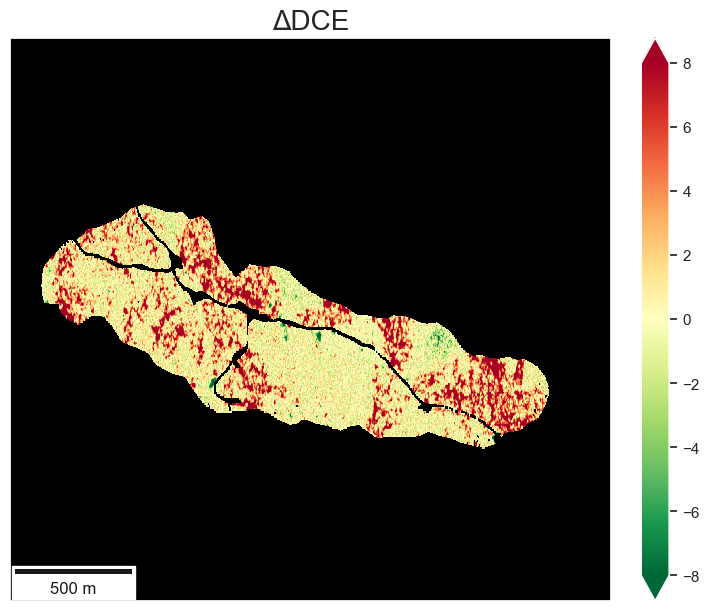

In [14]:
fig = plt.figure(figsize=(7,6), constrained_layout = True)
ax = fig.gca()

ds['diff_dce_rapid_ncalm'].plot(cmap='RdYlGn_r', vmin=-8, vmax=8, cbar_kwargs={'label':''})

plt.title('')

ax.set_facecolor('black')
# ax.set_facecolor('EAEAF2')
scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left') #rotation='horizontal-only'
ax.add_artist(scalebar)

plt.xlabel('');plt.ylabel('');plt.xticks([]);plt.yticks([])

plt.title('ΔDCE', fontsize=20)

plt.show()

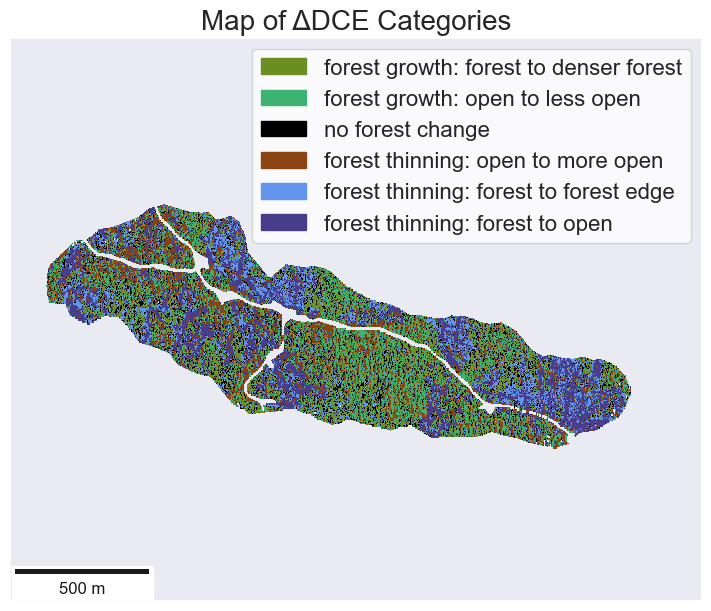

In [15]:
fig = plt.figure(figsize=(7,6), constrained_layout = True)
ax = fig.gca()

# color_zero = 'white'
color_zero = '#EAEAF2'

# plot 3
ds['delta_dce_cat'].plot(cmap=ListedColormap([color_zero, color_cat1,color_cat2,color_cat3,color_cat4,color_cat5,color_cat6]), add_colorbar=False)  

# Add a legend for labels, to have different labels for each plot
legend_labels2 = {color_cat1: "forest growth: forest to denser forest", 
                  color_cat4: "forest growth: open to less open",
                  color_cat3: "no forest change",  
                  color_cat5: "forest thinning: open to more open",               
                  color_cat2: "forest thinning: forest to forest edge",
                  color_cat6: "forest thinning: forest to open",}

patches2 = [Patch(color=color, label=label)
           for color, label in legend_labels2.items()]

plt.legend(handles=patches2,
          bbox_to_anchor=(1, 1),
          facecolor="white", fontsize=16, loc='upper right')

plt.title('')

ax.set_facecolor('black')
scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left') #rotation='horizontal-only'
ax.add_artist(scalebar)

plt.xlabel('');plt.ylabel('');plt.xticks([]);plt.yticks([])

# add a small C) in the left corner 
# plt.text(0.01, 0.95, 'C)', fontsize=18, color='dimgray', transform=ax.transAxes)20
plt.title('Map of ΔDCE Categories', fontsize=20)

# add very small text on the subplot C) which says "north" and "south" in small grey text 
# plt.text(0.53, 0.57, 'north side of the ridge', fontsize=fontsize_3, color='dimgray', transform=ax.transAxes) #(left/right, top/bottom, text)
# plt.text(0.15, 0.26, 'south side of the ridge', fontsize=fontsize_3, color='dimgray', transform=ax.transAxes)

# === Save and show ===
# figure_name = 'figure4_map_1.png'
# plt.savefig(figure_path + figure_name, dpi=500, bbox_inches='tight')

plt.show()

/home/cassie/programs/miniforge3/envs/cer_treatment/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


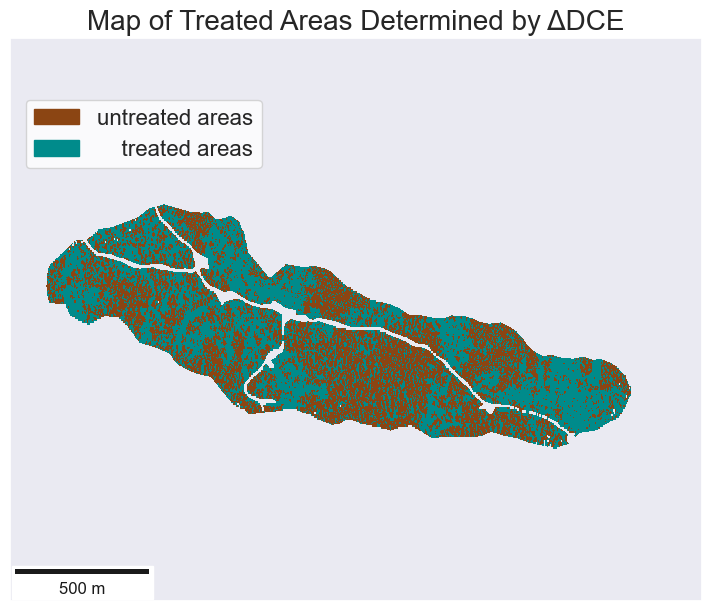

In [16]:
fig = plt.figure(figsize=(7,6), constrained_layout = True)
ax = fig.gca()

# color_zero = 'white'
color_zero = '#EAEAF2'

colorcontrol = 'saddlebrown'
colortreatment = 'darkcyan'

# plot 3
# ds['delta_dce_cat'].plot(cmap=ListedColormap([color_zero, color_cat1,color_cat2,color_cat3,color_cat4,color_cat5,color_cat6]), add_colorbar=False)  

# # Add a legend for labels, to have different labels for each plot
# legend_labels2 = {color_cat1: "forest growth: forest to denser forest", 
#                   color_cat4: "forest growth: open to less open",
#                   color_cat3: "no forest change",  
#                   color_cat5: "forest thinning: open to more open",               
#                   color_cat2: "forest thinning: forest to forest edge",
#                   color_cat6: "forest thinning: forest to open",}

ds['delta_dce_cat'].plot(cmap=ListedColormap([color_zero, colorcontrol, colortreatment, colorcontrol, colorcontrol, colortreatment, colortreatment]), add_colorbar=False)  

# Add a legend for labels, to have different labels for each plot
legend_labels2 = {colorcontrol:   "untreated areas", 
                  colortreatment: "    treated areas"}

patches2 = [Patch(color=color, label=label)
           for color, label in legend_labels2.items()]

plt.legend(handles=patches2,
          bbox_to_anchor=(0.38, .91),
          facecolor="white", fontsize=16)

plt.title('')

ax.set_facecolor('black')
scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left') #rotation='horizontal-only'
ax.add_artist(scalebar)

plt.xlabel('');plt.ylabel('');plt.xticks([]);plt.yticks([])

# add a small C) in the left corner 
# plt.text(0.01, 0.95, 'C)', fontsize=18, color='dimgray', transform=ax.transAxes)

plt.title('Map of Treated Areas Determined by ΔDCE', fontsize=20)

# plt.text(0.53, 0.57, 'north side of the ridge', fontsize=fontsize_3, color='dimgray', transform=ax.transAxes) #(left/right, top/bottom, text)
# plt.text(0.15, 0.26, 'south side of the ridge', fontsize=fontsize_3, color='dimgray', transform=ax.transAxes)

# === Save and show ===
# figure_name = 'figure4_map_2.png'
# plt.savefig(figure_path + figure_name, dpi=500, bbox_inches='tight')

plt.show()

# Put them together..

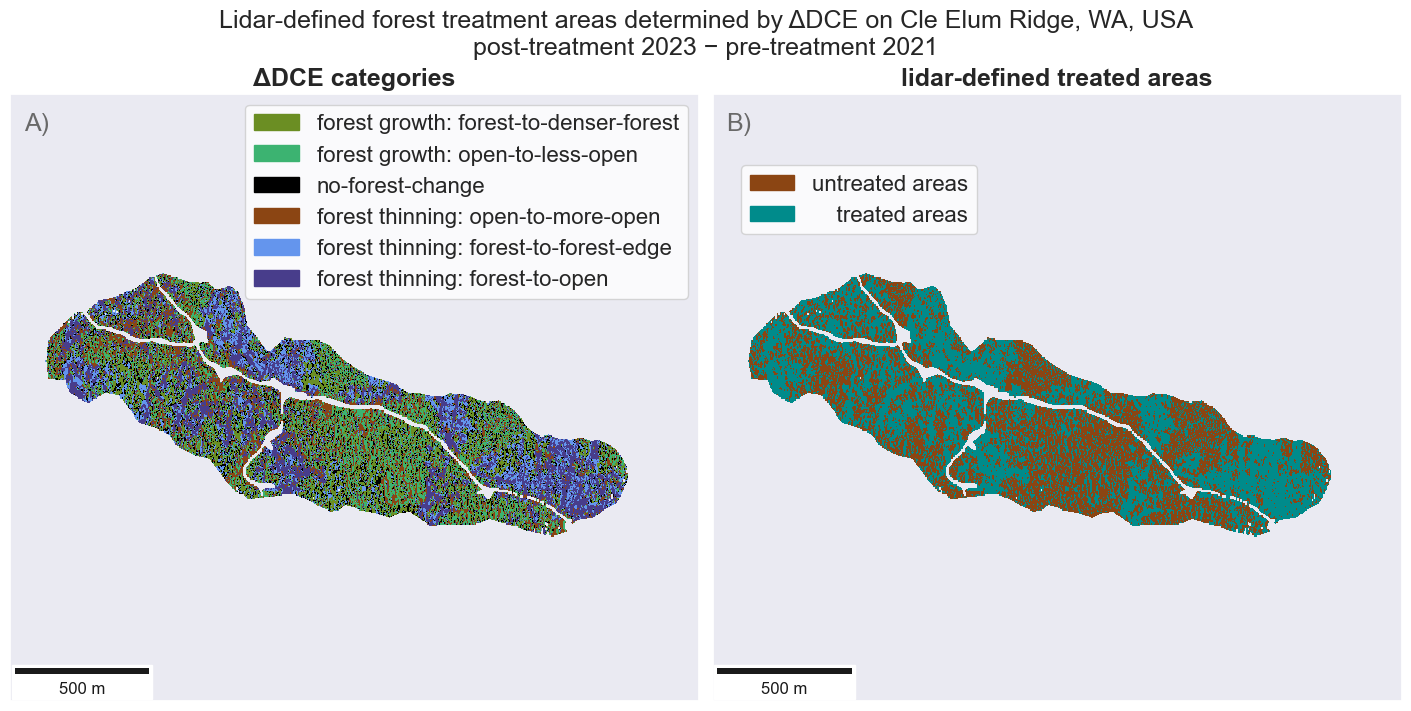

In [17]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(14,7), constrained_layout = True)

# color_zero = 'white'
color_zero = '#EAEAF2'

colorcontrol = 'saddlebrown'
colortreatment = 'darkcyan'

fontsize_title = 18

# ___________________________________________________________________________

ds['delta_dce_cat'].plot(ax=axes[0],cmap=ListedColormap([color_zero, color_cat1,color_cat2,color_cat3,color_cat4,color_cat5,color_cat6]), add_colorbar=False)  

# Add a legend for labels, to have different labels for each plot
# legend_labels2 = {color_cat1: "forest growth: forest to denser forest", 
#                   color_cat4: "forest growth: open to less open",
#                   color_cat3: "no forest change",  
#                   color_cat5: "forest thinning: open to more open",               
#                   color_cat2: "forest thinning: forest to forest edge",
#                   color_cat6: "forest thinning: forest to open",}

# legend_labels2 = {color_cat1: "forest growth: forest-to-denser-forest", 
#                   color_cat4: "forest growth: open-to-less-open",
#                   color_cat3: "no-forest-change",  
#                   color_cat5: "forest thinning: open-to-more-open",               
#                   color_cat2: "forest thinning: forest-to-forest-edge",
#                   color_cat6: "forest thinning: forest-to-open",}

# legend_labels2 = {
#     color_cat1: "forest growth: $\\it{forest\\ to\\ denser\\ forest}$", 
#     color_cat4: "forest growth: $\\it{open\\ to\\ less\\ open}$",
#     color_cat3: "$\\it{no\\ forest\\ change}$",  
#     color_cat5: "forest thinning: $\\it{open\\ to\\ more\\ open}$",               
#     color_cat2: "forest thinning: $\\it{forest\\ to\\ forest\\ edge}$",
#     color_cat6: "forest thinning: $\\it{forest\\ to\\ open}$",
# }

legend_labels2 = {
    color_cat1: "forest growth: forest-to-denser-forest", 
    color_cat4: "forest growth: open-to-less-open",
    color_cat3: "no-forest-change",  
    color_cat5: "forest thinning: open-to-more-open",               
    color_cat2: "forest thinning: forest-to-forest-edge",
    color_cat6: "forest thinning: forest-to-open",
}


patches2 = [Patch(color=color, label=label)
           for color, label in legend_labels2.items()]

leg = axes[0].legend(handles=patches2,
          bbox_to_anchor=(1, 1),
          facecolor="white", fontsize=16, loc='upper right')

axes[0].set_title('ΔDCE categories', fontweight = 'bold', fontsize=fontsize_title)
axes[0].set_facecolor('black')
scalebar = ScaleBar(1, "m", length_fraction=.25, location='lower left') #rotation='horizontal-only'
axes[0].add_artist(scalebar)

axes[0].set_xlabel('');axes[0].set_ylabel('');axes[0].set_xticks([]);axes[0].set_yticks([])

# for text in leg.get_texts():
#     label = text.get_text()

#     # If label contains a descriptor after a colon, italicize only that part
#     if ":" in label:
#         prefix, descriptor = label.split(":", 1)
#         text.set_text(f"{prefix}:{descriptor}")
#         text.set_fontstyle('italic')
#     else:
#         # Fully descriptive labels (e.g., "no-forest-change")
#         text.set_fontstyle('italic')


# ___________________________________________________________________________

ds['delta_dce_cat'].plot(ax=axes[1], cmap=ListedColormap([color_zero, colorcontrol, colortreatment, colorcontrol, colorcontrol, colortreatment, colortreatment]), add_colorbar=False)  

# Add a legend for labels, to have different labels for each plot
legend_labels2 = {colorcontrol:   "untreated areas", 
                  colortreatment: "    treated areas"}

patches2 = [Patch(color=color, label=label)
           for color, label in legend_labels2.items()]

axes[1].legend(handles=patches2,
        #   bbox_to_anchor=(1, 1), # change location later if we want it like we did with SDV post-processing 
          bbox_to_anchor=(0.4, .90), #(left/right, top/bottom, text)
          facecolor="white", fontsize=16, loc='upper right')    

# axes[1].set_title('untreated and treated areas', fontweight = 'bold', fontsize=fontsize_title)
axes[1].set_title('lidar-defined treated areas', fontweight = 'bold', fontsize=fontsize_title)

axes[1].set_facecolor('black')
scalebar = ScaleBar(1, "m", length_fraction=.25, location='lower left') #rotation='horizontal-only'
axes[1].add_artist(scalebar)

axes[1].set_xlabel('');axes[1].set_ylabel('');axes[1].set_xticks([]);axes[1].set_yticks([])

# ___________________________________________________________________________

color='dimgrey'
fontsize_AB = 18
axes[0].text(0.02, 0.94, 'A)', fontsize=fontsize_AB, color=color, transform=axes[0].transAxes)
axes[1].text(0.02, 0.94, 'B)', fontsize=fontsize_AB, color=color, transform=axes[1].transAxes)

# plt.suptitle('Treated Areas Determined by ΔDCE on Cle Elum Ridge, WA, USA\npost-treatment 2023- pre-treatment 2021', fontsize=18)
# plt.suptitle('Lidar-Defined Forest Treated Areas Determined by ΔDCE on Cle Elum Ridge, WA, USA\npost-treatment 2023 − pre-treatment 2021', fontsize=18)
plt.suptitle('Lidar-defined forest treatment areas determined by ΔDCE on Cle Elum Ridge, WA, USA\npost-treatment 2023 − pre-treatment 2021', fontsize=18)

# export the figure with high resolution
figure_name = 'figure4_final.png'
plt.savefig(figure_path + figure_name, dpi=600, bbox_inches="tight")

plt.show()

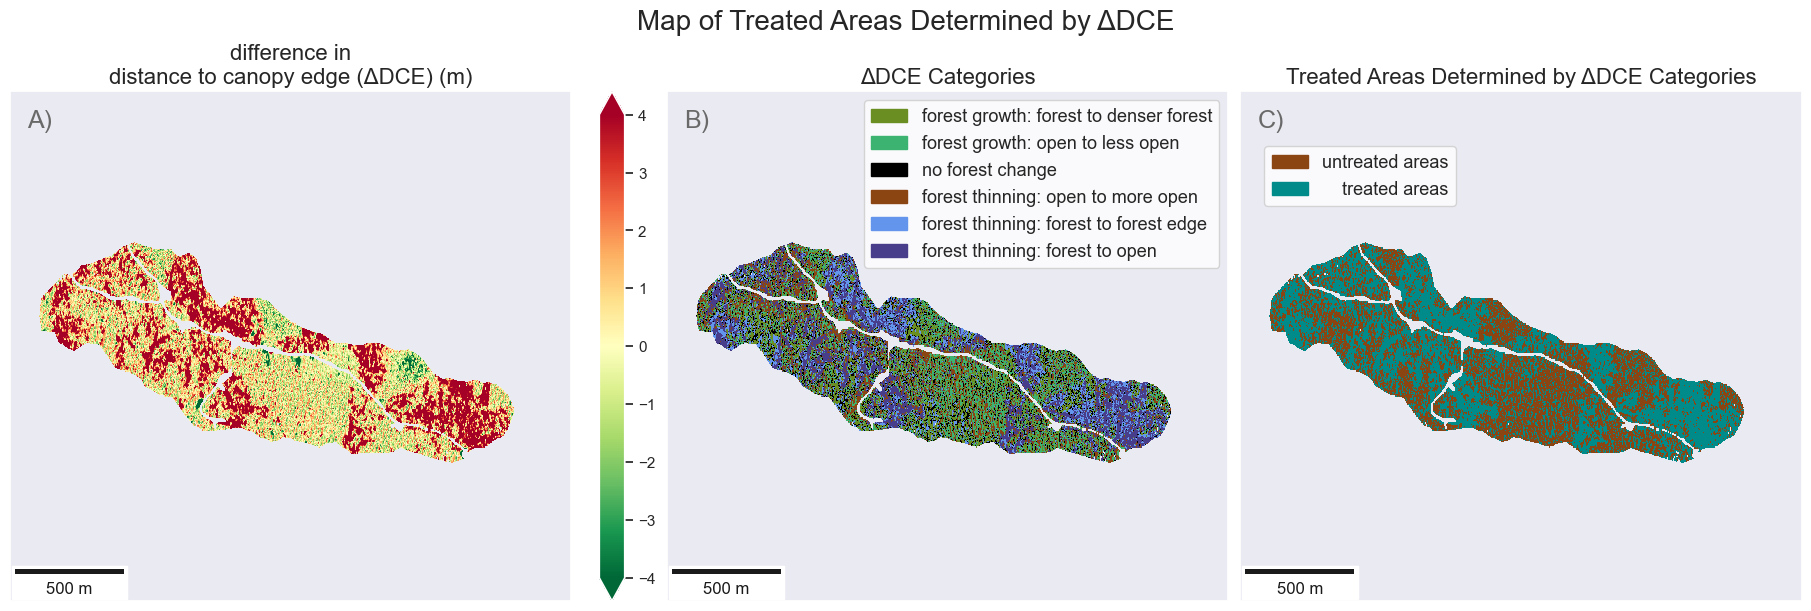

In [18]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(18,6), constrained_layout = True)

# color_zero = 'white'
color_zero = '#EAEAF2'

colorcontrol = 'saddlebrown'
colortreatment = 'darkcyan'

fontsize_title = 16
fontsize_legend = 13

# ___________________________________________________________________________

# ds['diff_dce_rapid_ncalm'].plot(ax=axes[0], cmap='RdYlGn_r', vmin=-8, vmax=8, cbar_kwargs={'label':''})
ds['diff_dce_rapid_ncalm'].plot(ax=axes[0], cmap='RdYlGn_r', vmin=-4, vmax=4, cbar_kwargs={'label':''})

axes[0].set_title('difference in\ndistance to canopy edge (ΔDCE) (m)', fontsize=fontsize_title)
# axes[0].set_title('ΔDCE', fontsize=fontsize_title)
# axes[0].set_facecolor('black')
scalebar = ScaleBar(1, "m", length_fraction=.25, location='lower left') #rotation='horizontal-only'
axes[0].add_artist(scalebar)

axes[0].set_xlabel('');axes[0].set_ylabel('');axes[0].set_xticks([]);axes[0].set_yticks([])

# ___________________________________________________________________________

ds['delta_dce_cat'].plot(ax=axes[1],cmap=ListedColormap([color_zero, color_cat1,color_cat2,color_cat3,color_cat4,color_cat5,color_cat6]), add_colorbar=False)  

# Add a legend for labels, to have different labels for each plot
legend_labels2 = {color_cat1: "forest growth: forest to denser forest", 
                  color_cat4: "forest growth: open to less open",
                  color_cat3: "no forest change",  
                  color_cat5: "forest thinning: open to more open",               
                  color_cat2: "forest thinning: forest to forest edge",
                  color_cat6: "forest thinning: forest to open",}

patches2 = [Patch(color=color, label=label)
           for color, label in legend_labels2.items()]

axes[1].legend(handles=patches2,
          bbox_to_anchor=(1, 1),
          facecolor="white", fontsize=fontsize_legend, loc='upper right')

axes[1].set_title('ΔDCE Categories', fontsize=fontsize_title)
axes[1].set_facecolor('black')
scalebar = ScaleBar(1, "m", length_fraction=.25, location='lower left') #rotation='horizontal-only'
axes[1].add_artist(scalebar)

axes[1].set_xlabel('');axes[1].set_ylabel('');axes[1].set_xticks([]);axes[1].set_yticks([])

# ___________________________________________________________________________

ds['delta_dce_cat'].plot(ax=axes[2], cmap=ListedColormap([color_zero, colorcontrol, colortreatment, colorcontrol, colorcontrol, colortreatment, colortreatment]), add_colorbar=False)  

# Add a legend for labels, to have different labels for each plot
legend_labels2 = {colorcontrol:   "untreated areas", 
                  colortreatment: "    treated areas"}

patches2 = [Patch(color=color, label=label)
           for color, label in legend_labels2.items()]

axes[2].legend(handles=patches2,
        #   bbox_to_anchor=(1, 1), # change location later if we want it like we did with SDV post-processing 
          bbox_to_anchor=(0.4, .91), #(left/right, top/bottom, text)
          facecolor="white", fontsize=fontsize_legend, loc='upper right')    

axes[2].set_title('Treated Areas Determined by ΔDCE Categories', fontsize=fontsize_title)
axes[2].set_facecolor('black')
scalebar = ScaleBar(1, "m", length_fraction=.25, location='lower left') #rotation='horizontal-only'
axes[2].add_artist(scalebar)

axes[2].set_xlabel('');axes[2].set_ylabel('');axes[2].set_xticks([]);axes[2].set_yticks([])

# ___________________________________________________________________________

color='dimgrey'
fontsize_AB = 18
axes[0].text(0.03, 0.93, 'A)', fontsize=fontsize_AB, color=color, transform=axes[0].transAxes)
axes[1].text(0.03, 0.93, 'B)', fontsize=fontsize_AB, color=color, transform=axes[1].transAxes)
axes[2].text(0.03, 0.93, 'C)', fontsize=fontsize_AB, color=color, transform=axes[2].transAxes)

# export the figure with high resolution
# figure_name = 'figure4_deltadce_treatments.png'
# plt.savefig(figure_path + figure_name, dpi=500)

plt.suptitle('Map of Treated Areas Determined by ΔDCE', fontsize=20)

plt.show()

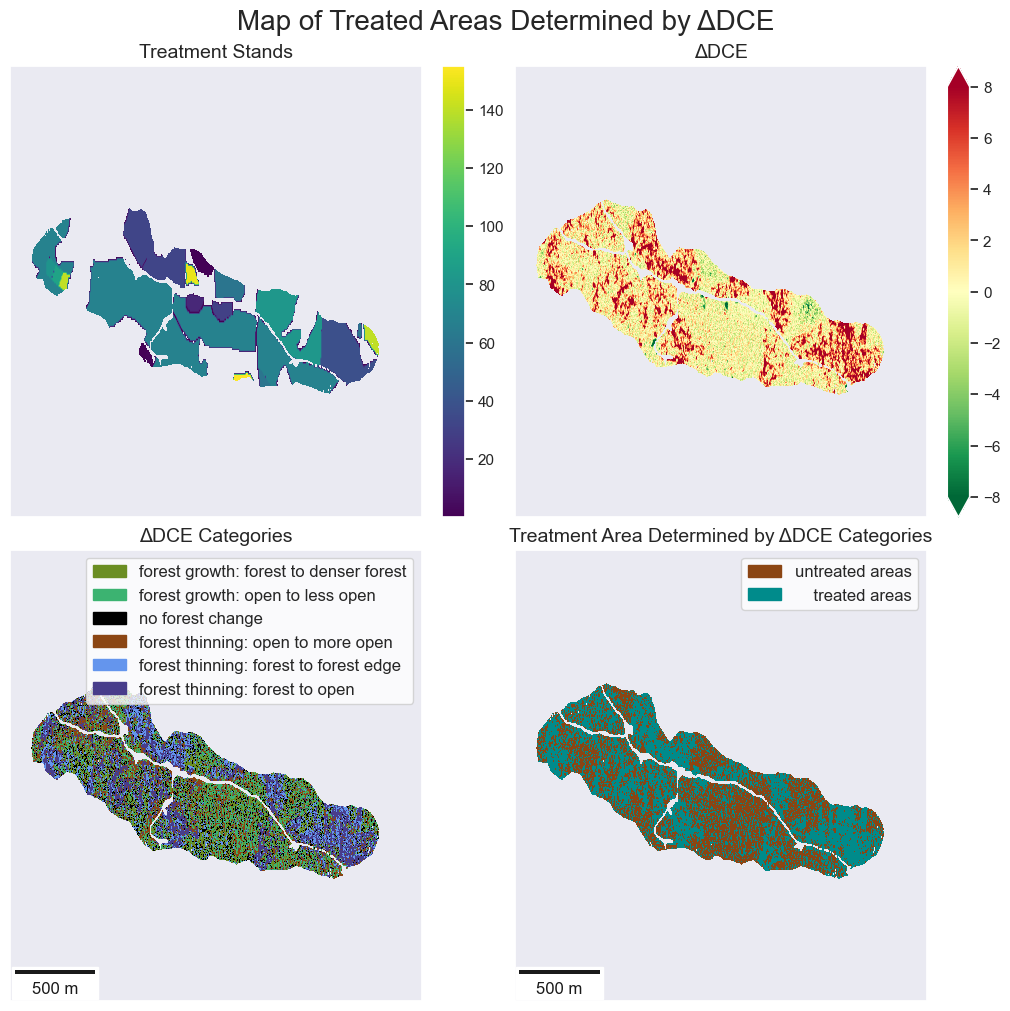

In [19]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,10), constrained_layout = True)
fontsize_num = 14

# color_zero = 'white'
color_zero = '#EAEAF2'

colorcontrol = 'saddlebrown'
colortreatment = 'darkcyan'

fontsize_title = 14
fontsize_legend = 12

# ___________________________________________________________________________

ds['baf'].plot(ax=axes[0,0], cbar_kwargs={'label':''})

axes[0,0].set_title('Treatment Stands', fontsize=fontsize_title)
axes[0,0].set_xlabel('');axes[0,0].set_ylabel('');axes[0,0].set_xticks([]);axes[0,0].set_yticks([])


# ___________________________________________________________________________

ds['diff_dce_rapid_ncalm'].plot(ax=axes[0,1], cmap='RdYlGn_r', vmin=-8, vmax=8, cbar_kwargs={'label':''})

axes[0,1].set_title('ΔDCE', fontsize=fontsize_title)
axes[0,1].set_xlabel('');axes[0,1].set_ylabel('');axes[0,1].set_xticks([]);axes[0,1].set_yticks([])

# ___________________________________________________________________________

ds['delta_dce_cat'].plot(ax=axes[1,0],cmap=ListedColormap([color_zero, color_cat1,color_cat2,color_cat3,color_cat4,color_cat5,color_cat6]), add_colorbar=False)  

# Add a legend for labels, to have different labels for each plot
legend_labels2 = {color_cat1: "forest growth: forest to denser forest", 
                  color_cat4: "forest growth: open to less open",
                  color_cat3: "no forest change",  
                  color_cat5: "forest thinning: open to more open",               
                  color_cat2: "forest thinning: forest to forest edge",
                  color_cat6: "forest thinning: forest to open",}

patches2 = [Patch(color=color, label=label)
           for color, label in legend_labels2.items()]

axes[1,0].legend(handles=patches2,
          bbox_to_anchor=(1, 1),
          facecolor="white", fontsize=fontsize_legend, loc='upper right')

axes[1,0].set_title('ΔDCE Categories', fontsize=fontsize_title)
axes[1,0].set_facecolor('black')
scalebar = ScaleBar(1, "m", length_fraction=.25, location='lower left') #rotation='horizontal-only'
axes[1,0].add_artist(scalebar)

axes[1,0].set_xlabel('');axes[1,0].set_ylabel('');axes[1,0].set_xticks([]);axes[1,0].set_yticks([])

# ___________________________________________________________________________
ds['delta_dce_cat'].plot(ax=axes[1,1], cmap=ListedColormap([color_zero, colorcontrol, colortreatment, colorcontrol, colorcontrol, colortreatment, colortreatment]), add_colorbar=False)  

# Add a legend for labels, to have different labels for each plot
legend_labels2 = {colorcontrol:   "untreated areas", 
                  colortreatment: "    treated areas"}

patches2 = [Patch(color=color, label=label)
           for color, label in legend_labels2.items()]

axes[1,1].legend(handles=patches2,
          bbox_to_anchor=(1, 1), # change location later if we want it like we did with SDV post-processing 
          facecolor="white", fontsize=fontsize_legend, loc='upper right')    

axes[1,1].set_title('Treatment Area Determined by ΔDCE Categories', fontsize=fontsize_title)
axes[1,1].set_facecolor('black')
scalebar = ScaleBar(1, "m", length_fraction=.25, location='lower left') #rotation='horizontal-only'
axes[1,1].add_artist(scalebar)

axes[1,1].set_xlabel('');axes[1,1].set_ylabel('');axes[1,1].set_xticks([]);axes[1,1].set_yticks([])
# ___________________________________________________________________________


# SET CONSTANTS _____________________________________________________________

# add a small C) in the left corner 
# axes[1,1].set_text(1.01, 1.95, 'C)', fontsize=18, color='dimgray', transform=ax.transAxes)

plt.suptitle('Map of Treated Areas Determined by ΔDCE', fontsize=20)


plt.show()